Building on top of two-model solution.

How do you want to integrate original data?
1.  Target mean encoding from original data
2. Build XGB on original dataset, predict and append to dataframe (No effect)

# Functions

In [16]:
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool, cv

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np



def xgb_cross_val_regression(X_train, y_train, params=None, n_folds=5, num_boost_round=100, early_stopping_rounds=10, seed=42):
    """
    Performs k-fold cross-validation with XGBoost for a regression task.

    Args:
        X_train (pd.DataFrame or numpy.ndarray): Training features.
        y_train (pd.Series or numpy.ndarray): Training target variable.
        params (dict, optional): XGBoost parameters. Defaults to a basic set.
        n_folds (int): Number of folds for cross-validation.
        num_boost_round (int): Maximum number of boosting rounds.
        early_stopping_rounds (int): Stops training early if performance doesn't improve.
        seed (int): Random seed for reproducibility.

    Returns:
        dict: A dictionary containing:
            - 'cv_results': Pandas DataFrame of cross-validation results.
            - 'oof_predictions': Numpy array of out-of-fold predictions.
            - 'mean_rmse': Mean RMSE across all folds.
            - 'std_rmse': Standard deviation of RMSE across all folds.
            - 'best_n_estimators': The average best number of estimators from each fold.
    """

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    oof_predictions = np.zeros(len(y_train))
    rmse_scores = []
    best_n_estimators_list = []

    if params is None:
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'learning_rate': 0.1,
            'seed': seed
        }

    for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        print(f"Fold {fold+1}")
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

        cv_results_fold = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=[(dval, 'val')],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )

        best_n_estimators_fold = cv_results_fold.best_iteration + 1
        best_n_estimators_list.append(best_n_estimators_fold)

        y_pred_val = cv_results_fold.predict(dval, iteration_range=(0, cv_results_fold.best_iteration))
        oof_predictions[val_index] = y_pred_val
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
        rmse_scores.append(rmse)
        print(f"Fold {fold+1} RMSE: {rmse}, Best n_estimators: {best_n_estimators_fold}")

    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    avg_best_n_estimators = int(np.mean(best_n_estimators_list))

    print(f"\nMean Cross-Validation RMSE: {mean_rmse:.4f}")
    print(f"Standard Deviation of RMSE: {std_rmse:.4f}")
    print(f"Average Best n_estimators: {avg_best_n_estimators}")

    cv_results_df = pd.DataFrame({'fold': range(1, n_folds + 1), 'rmse': rmse_scores, 'best_n_estimators': best_n_estimators_list})

    return {
        'cv_results': cv_results_df,
        'oof_predictions': oof_predictions,
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse,
        'best_n_estimators': avg_best_n_estimators
    }

def xgb_predictor(X_train, y_train, X_test, params, num_boost_round=100, seed=42):
    """
    Performs k-fold cross-validation with XGBoost for a regression task.

    Args:
        X_train (pd.DataFrame or numpy.ndarray): Training features.
        y_train (pd.Series or numpy.ndarray): Training target variable.
        X_test (pd.DataFrame or numpy.ndarray): Test features.
        params (dict, optional): XGBoost parameters. Defaults to a basic set.
        n_folds (int): Number of folds for cross-validation.
        num_boost_round (int): Maximum number of boosting rounds.
        early_stopping_rounds (int): Stops training early if performance doesn't improve.
        seed (int): Random seed for reproducibility.

    Returns:
        dict: A dictionary containing:
            - 'cv_results': Pandas DataFrame of cross-validation results.
            - 'oof_predictions': Numpy array of out-of-fold predictions.
            - 'mean_rmse': Mean RMSE across all folds.
            - 'std_rmse': Standard deviation of RMSE across all folds.
            - 'best_n_estimators': The average best number of estimators from each fold.
    """
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    if params is None:
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'learning_rate': 0.1,
            'seed': seed
        }

    model = xgb.train(dtrain=dtrain, num_boost_round=num_boost_round, params=params)
    y_pred = model.predict(dtest)
    return y_pred


def lgbm_cross_val_regression(X_train, y_train, params=None, n_folds=5, num_boost_round=100, early_stopping_rounds=10, seed=42):
    """
    Performs k-fold cross-validation with LightGBM for a regression task.

    Args:
        X_train (pd.DataFrame or numpy.ndarray): Training features.
        y_train (pd.Series or numpy.ndarray): Training target variable.
        params (dict, optional): LightGBM parameters. Defaults to a basic set.
        n_folds (int): Number of folds for cross-validation.
        num_boost_round (int): Maximum number of boosting rounds.
        early_stopping_rounds (int): Stops training early if performance doesn't improve on validation folds.
        seed (int): Random seed for reproducibility.

    Returns:
        dict: A dictionary containing:
            - 'cv_results': Pandas DataFrame of cross-validation results.
            - 'oof_predictions': Numpy array of out-of-fold predictions.
            - 'mean_rmse': Mean RMSE across all folds.
            - 'std_rmse': Standard deviation of RMSE across all folds.
            - 'best_n_estimators': The average best number of estimators from each fold.
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    oof_predictions = np.zeros(len(y_train))
    rmse_scores = []
    best_n_estimators_list = []

    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.1,
            'n_estimators': num_boost_round,
            'random_state': seed
        }

    for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        print(f"Fold {fold+1}")
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
        lgb_eval = lgb.Dataset(X_val_fold, y_val_fold, reference=lgb_train)

        model = lgb.train(params, lgb_train, num_boost_round=num_boost_round,
                          valid_sets=[lgb_eval])

        best_n_estimators_fold = model.best_iteration
        best_n_estimators_list.append(best_n_estimators_fold)

        y_pred_val = model.predict(X_val_fold, num_iteration=best_n_estimators_fold)
        oof_predictions[val_index] = y_pred_val
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
        rmse_scores.append(rmse)
        print(f"Fold {fold+1} RMSE: {rmse:.4f}, Best n_estimators: {best_n_estimators_fold}")

    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    avg_best_n_estimators = int(np.mean(best_n_estimators_list))

    print(f"\nMean Cross-Validation RMSE: {mean_rmse:.4f}")
    print(f"Standard Deviation of RMSE: {std_rmse:.4f}")
    print(f"Average Best n_estimators: {avg_best_n_estimators}")

    cv_results_df = pd.DataFrame({'fold': range(1, n_folds + 1), 'rmse': rmse_scores, 'best_n_estimators': best_n_estimators_list})

    return {
        'cv_results': cv_results_df,
        'oof_predictions': oof_predictions,
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse,
        'best_n_estimators': avg_best_n_estimators
    }

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def catboost_cross_val_regression(X_train, y_train, cat_features=None, params=None, n_folds=5, num_boost_round=100, early_stopping_rounds=10, seed=42, verbose=0):
    """
    Performs k-fold cross-validation with CatBoost for a regression task.

    Args:
        X_train (pd.DataFrame or numpy.ndarray): Training features.
        y_train (pd.Series or numpy.ndarray): Training target variable.
        cat_features (list, optional): List of categorical feature names or indices. Defaults to None.
        params (dict, optional): CatBoost parameters. Defaults to a basic set.
        n_folds (int): Number of folds for cross-validation.
        num_boost_round (int): Maximum number of boosting rounds.
        early_stopping_rounds (int): Stops training early if performance doesn't improve on validation folds.
        seed (int): Random seed for reproducibility.
        verbose (int): Verbosity level during training (0 for silent, >0 for output).

    Returns:
        dict: A dictionary containing:
            - 'cv_results': Pandas DataFrame of cross-validation results.
            - 'oof_predictions': Numpy array of out-of-fold predictions.
            - 'mean_rmse': Mean RMSE across all folds.
            - 'std_rmse': Standard deviation of RMSE across all folds.
            - 'best_iteration': The average best iteration across all folds.
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    oof_predictions = np.zeros(len(y_train))
    rmse_scores = []
    best_iteration_list = []

    if params is None:
        params = {
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'learning_rate': 0.1,
            'iterations': num_boost_round,
            'random_seed': seed,
            'verbose': verbose
        }
    else:
        params['iterations'] = num_boost_round
        params['random_seed'] = seed
        params['verbose'] = verbose

    for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        print(f"Fold {fold+1}")
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features)
        val_pool = Pool(X_val_fold, y_val_fold, cat_features=cat_features)

        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=early_stopping_rounds, verbose=verbose)

        best_iteration_fold = model.best_iteration_
        best_iteration_list.append(best_iteration_fold)

        y_pred_val = model.predict(X_val_fold)
        oof_predictions[val_index] = y_pred_val
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
        rmse_scores.append(rmse)
        print(f"Fold {fold+1} RMSE: {rmse:.4f}, Best iteration: {best_iteration_fold}")

    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    avg_best_iteration = int(np.mean(best_iteration_list))

    print(f"\nMean Cross-Validation RMSE: {mean_rmse:.4f}")
    print(f"Standard Deviation of RMSE: {std_rmse:.4f}")
    print(f"Average Best Iteration: {avg_best_iteration}")

    cv_results_df = pd.DataFrame({'fold': range(1, n_folds + 1), 'rmse': rmse_scores, 'best_iteration': best_iteration_list})

    return {
        'cv_results': cv_results_df,
        'oof_predictions': oof_predictions,
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse,
        'best_iteration': avg_best_iteration
    }

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# Data Loading and Preprocessing

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


train = pd.read_csv('content/train.csv')
test = pd.read_csv('content/test.csv')
orig = pd.read_csv('content/podcast_dataset.csv')
orig = orig[orig['Listening_Time_minutes'].notna()]

# Convert categorical columns to 'category' dtype
episode_title_as_numeric = True

# Treat Episode Length as numerical
if episode_title_as_numeric:
  train['Episode_Title'] = (train['Episode_Title'].str.replace('Episode', '')).astype(int)
  test['Episode_Title'] = (test['Episode_Title'].str.replace('Episode', '')).astype(int)
  orig['Episode_Title'] = (orig['Episode_Title'].str.replace('Episode', '')).astype(int)
  categorical_columns = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

else:
  categorical_columns = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment', 'Episode_Title']

# Convert Object Columns to 'category' type
for col in categorical_columns:
  label_encoder = LabelEncoder()
  train[col] = label_encoder.fit_transform(train[col])
  test[col] = label_encoder.transform(test[col])
  orig[col] = label_encoder.transform(orig[col])

predictors = ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment']

target = 'Listening_Time_minutes'

In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

EL_yes_train = train['Episode_Length_minutes'].notna() # Episode Length Present
EL_no_train = ~EL_yes_train

EL_yes_test = test['Episode_Length_minutes'].notna() # Episode Length Present
EL_no_test = ~EL_yes_test

EL_yes_orig = orig['Episode_Length_minutes'].notna() # Episode Length Present
EL_no_orig = ~EL_yes_orig

# LGBM

In [10]:
X, y = train[EL_yes_train][predictors], train[EL_yes_train][target]

lgbm_cross_val_regression(X_train=X, y_train=y, params=None)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 530325, number of used features: 10
[LightGBM] [Info] Start training from score 45.751311
Fold 1 RMSE: 10.3985, Best n_estimators: 0
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 530325, number of used features: 10
[LightGBM] [Info] Start training from score 45.760811
Fold 2 RMSE: 10.4030, Best n_estimators: 0
Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testi

{'cv_results':    fold       rmse  best_n_estimators
 0     1  10.398466                  0
 1     2  10.402999                  0
 2     3  10.404356                  0
 3     4  10.369344                  0
 4     5  10.409922                  0,
 'oof_predictions': array([84.48322658, 54.32366362, 48.27634874, ..., 20.15806497,
        77.61470643, 16.08049556]),
 'mean_rmse': np.float64(10.397017412980686),
 'std_rmse': np.float64(0.014311456759450584),
 'best_n_estimators': 0}

In [12]:
X, y = train[~EL_yes_train][predictors], train[~EL_yes_train][target]

lgbm_cross_val_regression(X_train=X, y_train=y, params=None)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 69674, number of used features: 9
[LightGBM] [Info] Start training from score 43.124299
Fold 1 RMSE: 25.2616, Best n_estimators: 0
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 69674, number of used features: 9
[LightGBM] [Info] Start training from score 43.148907
Fold 2 RMSE: 25.4474, Best n_estimators: 0
Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing w

{'cv_results':    fold       rmse  best_n_estimators
 0     1  25.261598                  0
 1     2  25.447352                  0
 2     3  25.377586                  0
 3     4  25.266766                  0
 4     5  25.199793                  0,
 'oof_predictions': array([47.96015451, 40.24239228, 44.98844274, ..., 44.97843167,
        41.97116621, 38.9413172 ]),
 'mean_rmse': np.float64(25.310618679420333),
 'std_rmse': np.float64(0.0892066417663512),
 'best_n_estimators': 0}

## Generate Predictions

In [ ]:
y_pred_1 = xgb_predictor(X_train=train[EL_yes_train][new_predictors], y_train=train[EL_yes_train][target], X_test=test[EL_yes_test][new_predictors], params=None)

y_pred_2 = xgb_predictor(X_train=train[~EL_yes_train][new_predictors], y_train=train[~EL_yes_train][target], X_test=test[~EL_yes_test][new_predictors], params=None)

y_pred = np.zeros(len(test))

y_pred[EL_yes_test] = y_pred_1

y_pred[~EL_yes_test] = y_pred_2

array([55.464706 , 18.452648 , 49.276478 , ...,  6.8242617, 73.48498  ,
       57.638653 ], dtype=float32)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# Load the data
train = pd.read_csv('/content/train.csv')

# Impute Missing Values with Medians
columns_to_impute = ['Guest_Popularity_percentage']
imputation_medians = train[columns_to_impute].median()
# train[columns_to_impute] = train[columns_to_impute].fillna(imputation_medians)
# test[columns_to_impute] = test[columns_to_impute].fillna(imputation_medians)

# Remove Missing Values
# train, test = train.dropna(), test.dropna()

# Remove rows where ads>3
train = train[~(train['Number_of_Ads']>3)]

# Remove rows with episode > 150 minutes
train = train[~(train['Episode_Length_minutes']>150)]

# Convert categorical columns to 'category' dtype
episode_title_as_numeric = True

# Treat Episode Length as numerical
if episode_title_as_numeric:
  train['Episode_Title'] = (train['Episode_Title'].str.replace('Episode', '')).astype(int)
  # test['Episode_Title'] = (test['Episode_Title'].str.replace('Episode', '')).astype(int)
  categorical_columns = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

else:
  categorical_columns = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment', 'Episode_Title']

# Convert Object Columns to 'category' type
for col in categorical_columns:
    train[col] = train[col].astype('category')
    # test[col] = test[col].astype('category')

predictors = ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment']

target = 'Listening_Time_minutes'

X, y = train[predictors], train[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
indices_train_model_1 = X_train['Episode_Length_minutes'].notna()
indices_train_model_2 = ~indices_train_model_1
# X_train['Episode_Length_minutes'].notna().sum()/ X_train.shape[0], X_val['Episode_Length_minutes'].notna().sum()/ X_val.shape[0]

indices_val_model_1 = X_val['Episode_Length_minutes'].notna()
indices_val_model_2 = ~indices_val_model_1

indices_train_model_1.sum(), indices_val_model_1.sum()

(np.int64(530285), np.int64(132612))

In [ ]:
# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train[indices_train_model_1], label=y_train[indices_train_model_1], enable_categorical=True)
dval = xgb.DMatrix(X_val[indices_val_model_1], label=y_val[indices_val_model_1], enable_categorical=True)


# Train an XGBoost model
param = {'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'learning_rate': 0.05,     # Step size shrinkage to prevent overfitting
#     'gamma': 0,               # Minimum loss reduction required to make a further partition on a leaf node
#     'max_depth': 20,           # Maximum depth of a tree. Increasing it increases model complexity.
#     'min_child_weight': 2,    # Minimum sum of instance weight needed in a child. Higher values prevent overfitting.
#     'subsample': 1,           # Subsample ratio of the training instances.
#     'colsample_bytree': 0.5,    # Subsample ratio of columns when constructing each tree.
#     'colsample_bylevel': 1,   # Subsample ratio of columns for each level.
#     'reg_alpha': 0.5,           # L1 regularization term on weights
#     'reg_lambda': 0,          # L2 regularization term on weights
#     'seed': 42,
#     'tree_method': 'gpu_hist'
# }
model_1 = xgb.train(param, dtrain, num_boost_round=100)

y_pred_1 = model_1.predict(dval)
mse_1 = mean_squared_error(y_val[indices_val_model_1], y_pred_1)
print(f"Model 1 RMSE: {np.sqrt(mse_1)}")


Model 1 RMSE: 10.35894093113034


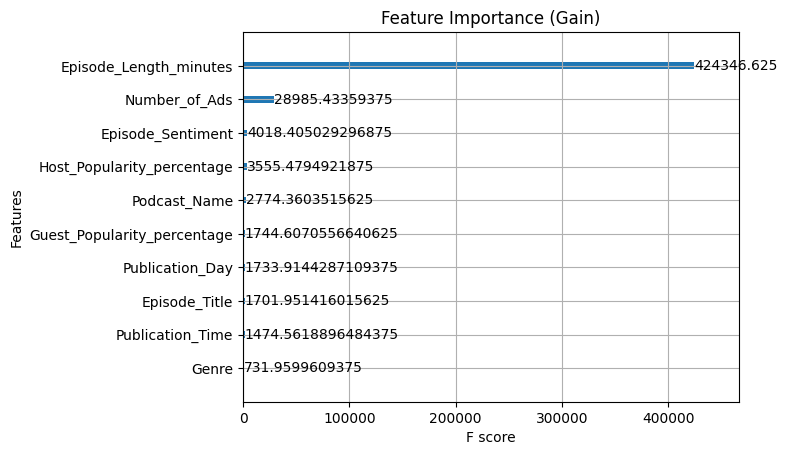

In [ ]:
xgb.plot_importance(model_1, importance_type='gain')
plt.title("Feature Importance (Gain)")
plt.show()

In [ ]:
# Prepare DMatrix for XGBoost
# dtrain = xgb.DMatrix(X_train[indices_train_model_2], label=y_train[indices_train_model_2], enable_categorical=True)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val[indices_val_model_2], label=y_val[indices_val_model_2], enable_categorical=True)


# Train an XGBoost model
# params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
# Define parameters
# Define parameters for hyperparameter tuning
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,     # Step size shrinkage to prevent overfitting
    'gamma': 0,               # Minimum loss reduction required to make a further partition on a leaf node
    'max_depth': 20,           # Maximum depth of a tree. Increasing it increases model complexity.
    'min_child_weight': 2,    # Minimum sum of instance weight needed in a child. Higher values prevent overfitting.
    'subsample': 1,           # Subsample ratio of the training instances.
    'colsample_bytree': 0.5,    # Subsample ratio of columns when constructing each tree.
    'colsample_bylevel': 1,   # Subsample ratio of columns for each level.
    'reg_alpha': 0.5,           # L1 regularization term on weights
    'reg_lambda': 0,          # L2 regularization term on weights
    'seed': 42,
    'tree_method': 'gpu_hist'
}

model_2 = xgb.train(params, dtrain, num_boost_round=100)

y_pred_2 = model_2.predict(dval)
mse_2 = mean_squared_error(y_val[indices_val_model_2], y_pred_2)
print(f"Model 2 RMSE: {np.sqrt(mse_2)}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:01:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:05:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Model 1 RMSE: 24.332786634455154


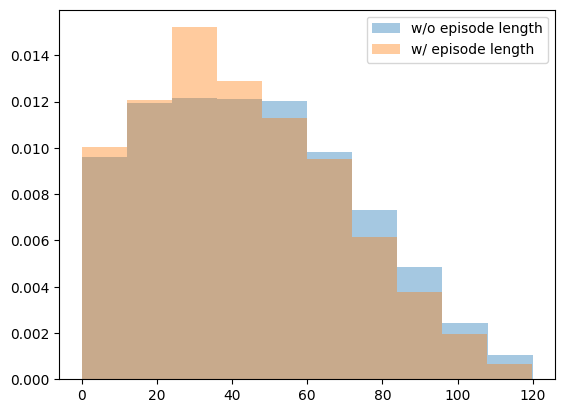

In [ ]:
plt.hist(y_val[indices_val_model_1], label='w/o episode length', density=True, alpha=0.4)
plt.hist(y_val[indices_val_model_2], label='w/ episode length', density=True, alpha=0.4)
plt.legend()
plt.show()

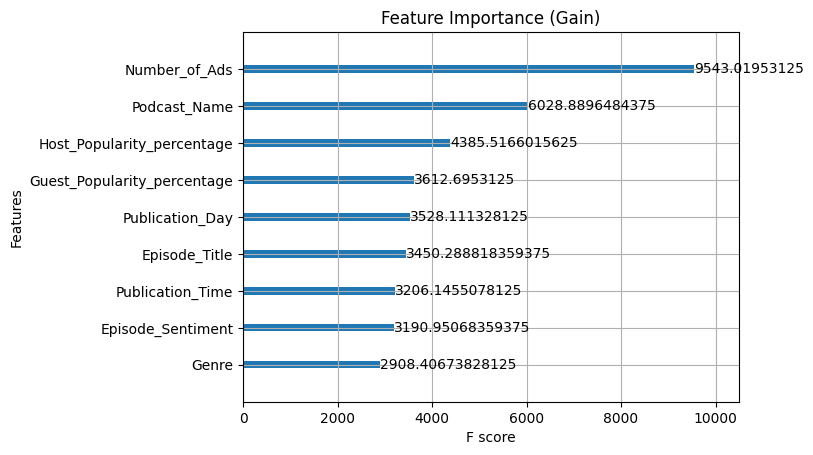

In [ ]:
xgb.plot_importance(model_2, importance_type='gain')
plt.title("Feature Importance (Gain)")
plt.show()

In [ ]:
y_pred = np.zeros_like(y_val)
y_pred[indices_val_model_1] = y_pred_1
y_pred[indices_val_model_2] = y_pred_2

mse = mean_squared_error(y_val, y_pred)
print(f"Model RMSE: {np.sqrt(mse)}")

Model RMSE: 12.786605294590373


# Generate Prediction

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# Load the data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# Impute Missing Values with Medians
columns_to_impute = ['Guest_Popularity_percentage']
imputation_medians = train[columns_to_impute].median()
# train[columns_to_impute] = train[columns_to_impute].fillna(imputation_medians)
# test[columns_to_impute] = test[columns_to_impute].fillna(imputation_medians)

# Remove Missing Values
# train, test = train.dropna(), test.dropna()

# Remove rows where ads>3
train = train[~(train['Number_of_Ads']>3)]

# Remove rows with episode > 150 minutes
train = train[~(train['Episode_Length_minutes']>150)]

# Convert categorical columns to 'category' dtype
episode_title_as_numeric = True

if episode_title_as_numeric:
  train['Episode_Title'] = (train['Episode_Title'].str.replace('Episode', '')).astype(int)
  test['Episode_Title'] = (test['Episode_Title'].str.replace('Episode', '')).astype(int)
  categorical_columns = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

else:
  categorical_columns = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment', 'Episode_Title']

for col in categorical_columns:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

# X, y = train[predictors], train[target]
X_train, X_val, y_train = train[predictors], test[predictors], train[target]

In [ ]:
indices_train_model_1 = X_train['Episode_Length_minutes'].notna()
indices_train_model_2 = ~indices_train_model_1
# X_train['Episode_Length_minutes'].notna().sum()/ X_train.shape[0], X_val['Episode_Length_minutes'].notna().sum()/ X_val.shape[0]

indices_val_model_1 = X_val['Episode_Length_minutes'].notna()
indices_val_model_2 = ~indices_val_model_1

indices_train_model_1.sum(), indices_val_model_1.sum()

(np.int64(662897), np.int64(221264))

In [ ]:
# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train[indices_train_model_1], label=y_train[indices_train_model_1], enable_categorical=True)
dval = xgb.DMatrix(X_val[indices_val_model_1], enable_categorical=True)


# Train an XGBoost model
param = {'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
model_1 = xgb.train(param, dtrain, num_boost_round=100)

y_pred_1 = model_1.predict(dval)
# mse_1 = mean_squared_error(y_val[indices_val_model_1], y_pred_1)
# print(f"Model 1 RMSE: {np.sqrt(mse_1)}")


In [34]:

params_deep = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,     # Step size shrinkage to prevent overfitting
    'gamma': 0,               # Minimum loss reduction required to make a further partition on a leaf node
    'max_depth': 20,           # Maximum depth of a tree. Increasing it increases model complexity.
    'min_child_weight': 2,    # Minimum sum of instance weight needed in a child. Higher values prevent overfitting.
    'subsample': 1,           # Subsample ratio of the training instances.
    'colsample_bytree': 0.5,    # Subsample ratio of columns when constructing each tree.
    'colsample_bylevel': 1,   # Subsample ratio of columns for each level.
    'reg_alpha': 0.5,           # L1 regularization term on weights
    'reg_lambda': 0,          # L2 regularization term on weights
    'seed': 42,
    # 'tree_method': 'gpu_hist'
}


In [ ]:
y_pred = np.zeros((X_val.shape[0]))
y_pred[indices_val_model_1] = y_pred_1
y_pred[indices_val_model_2] = y_pred_2

# Generate CSV from Output

In [31]:
df_submission =pd.read_csv('content/sample_submission.csv')
df_submission['Listening_Time_minutes'] = y_pred
df_submission.to_csv('submission.csv', index=False)

In [23]:
y_pred

array([nan, nan, nan, ..., nan, nan, nan])